##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
%pip install pandas 
%pip install matplotlib
%pip install seaborn
%pip install joblib
%pip install scikit-learn
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [4]:
# Can have as many cells as you want for code
import numpy as np
import pandas as pd
filepath = "./data/catA_train.csv" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

## Data Processing

In [70]:
df = pd.read_csv(filepath)

# dealing with missing data
df = df.dropna(subset = ["LATITUDE", "LONGITUDE"])

# One-Hot encoding
df = df[df['Company Status (Active/Inactive)'] == 'Active']
df['Import/Export Status_Missing'] = df['Import/Export Status'].isna()

df2 = df.dropna(subset=["Employees (Single Site)", "Employees (Domestic Ultimate Total)", "Employees (Global Ultimate Total)",
                                       "Year Found"])

df2 = pd.get_dummies(df, columns=['Entity Type'], prefix='Entity_Type')
df2 = pd.get_dummies(df, columns=['Ownership Type'], prefix='Ownership_Type')
df2 = pd.get_dummies(df, columns=['Import/Export Status'], prefix='Import_Export_Status')
df2 = df.drop(columns=[col for col in ["Company Status (Active/Inactive)", "Entity Type", 'Import/Export Status', 'Ownership Type'] if col in df2.columns], errors='ignore')

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df2['SIC Code'] = label_encoder.fit_transform(df2['SIC Code'])

## Exploratory Data Analysis


<AxesSubplot: >

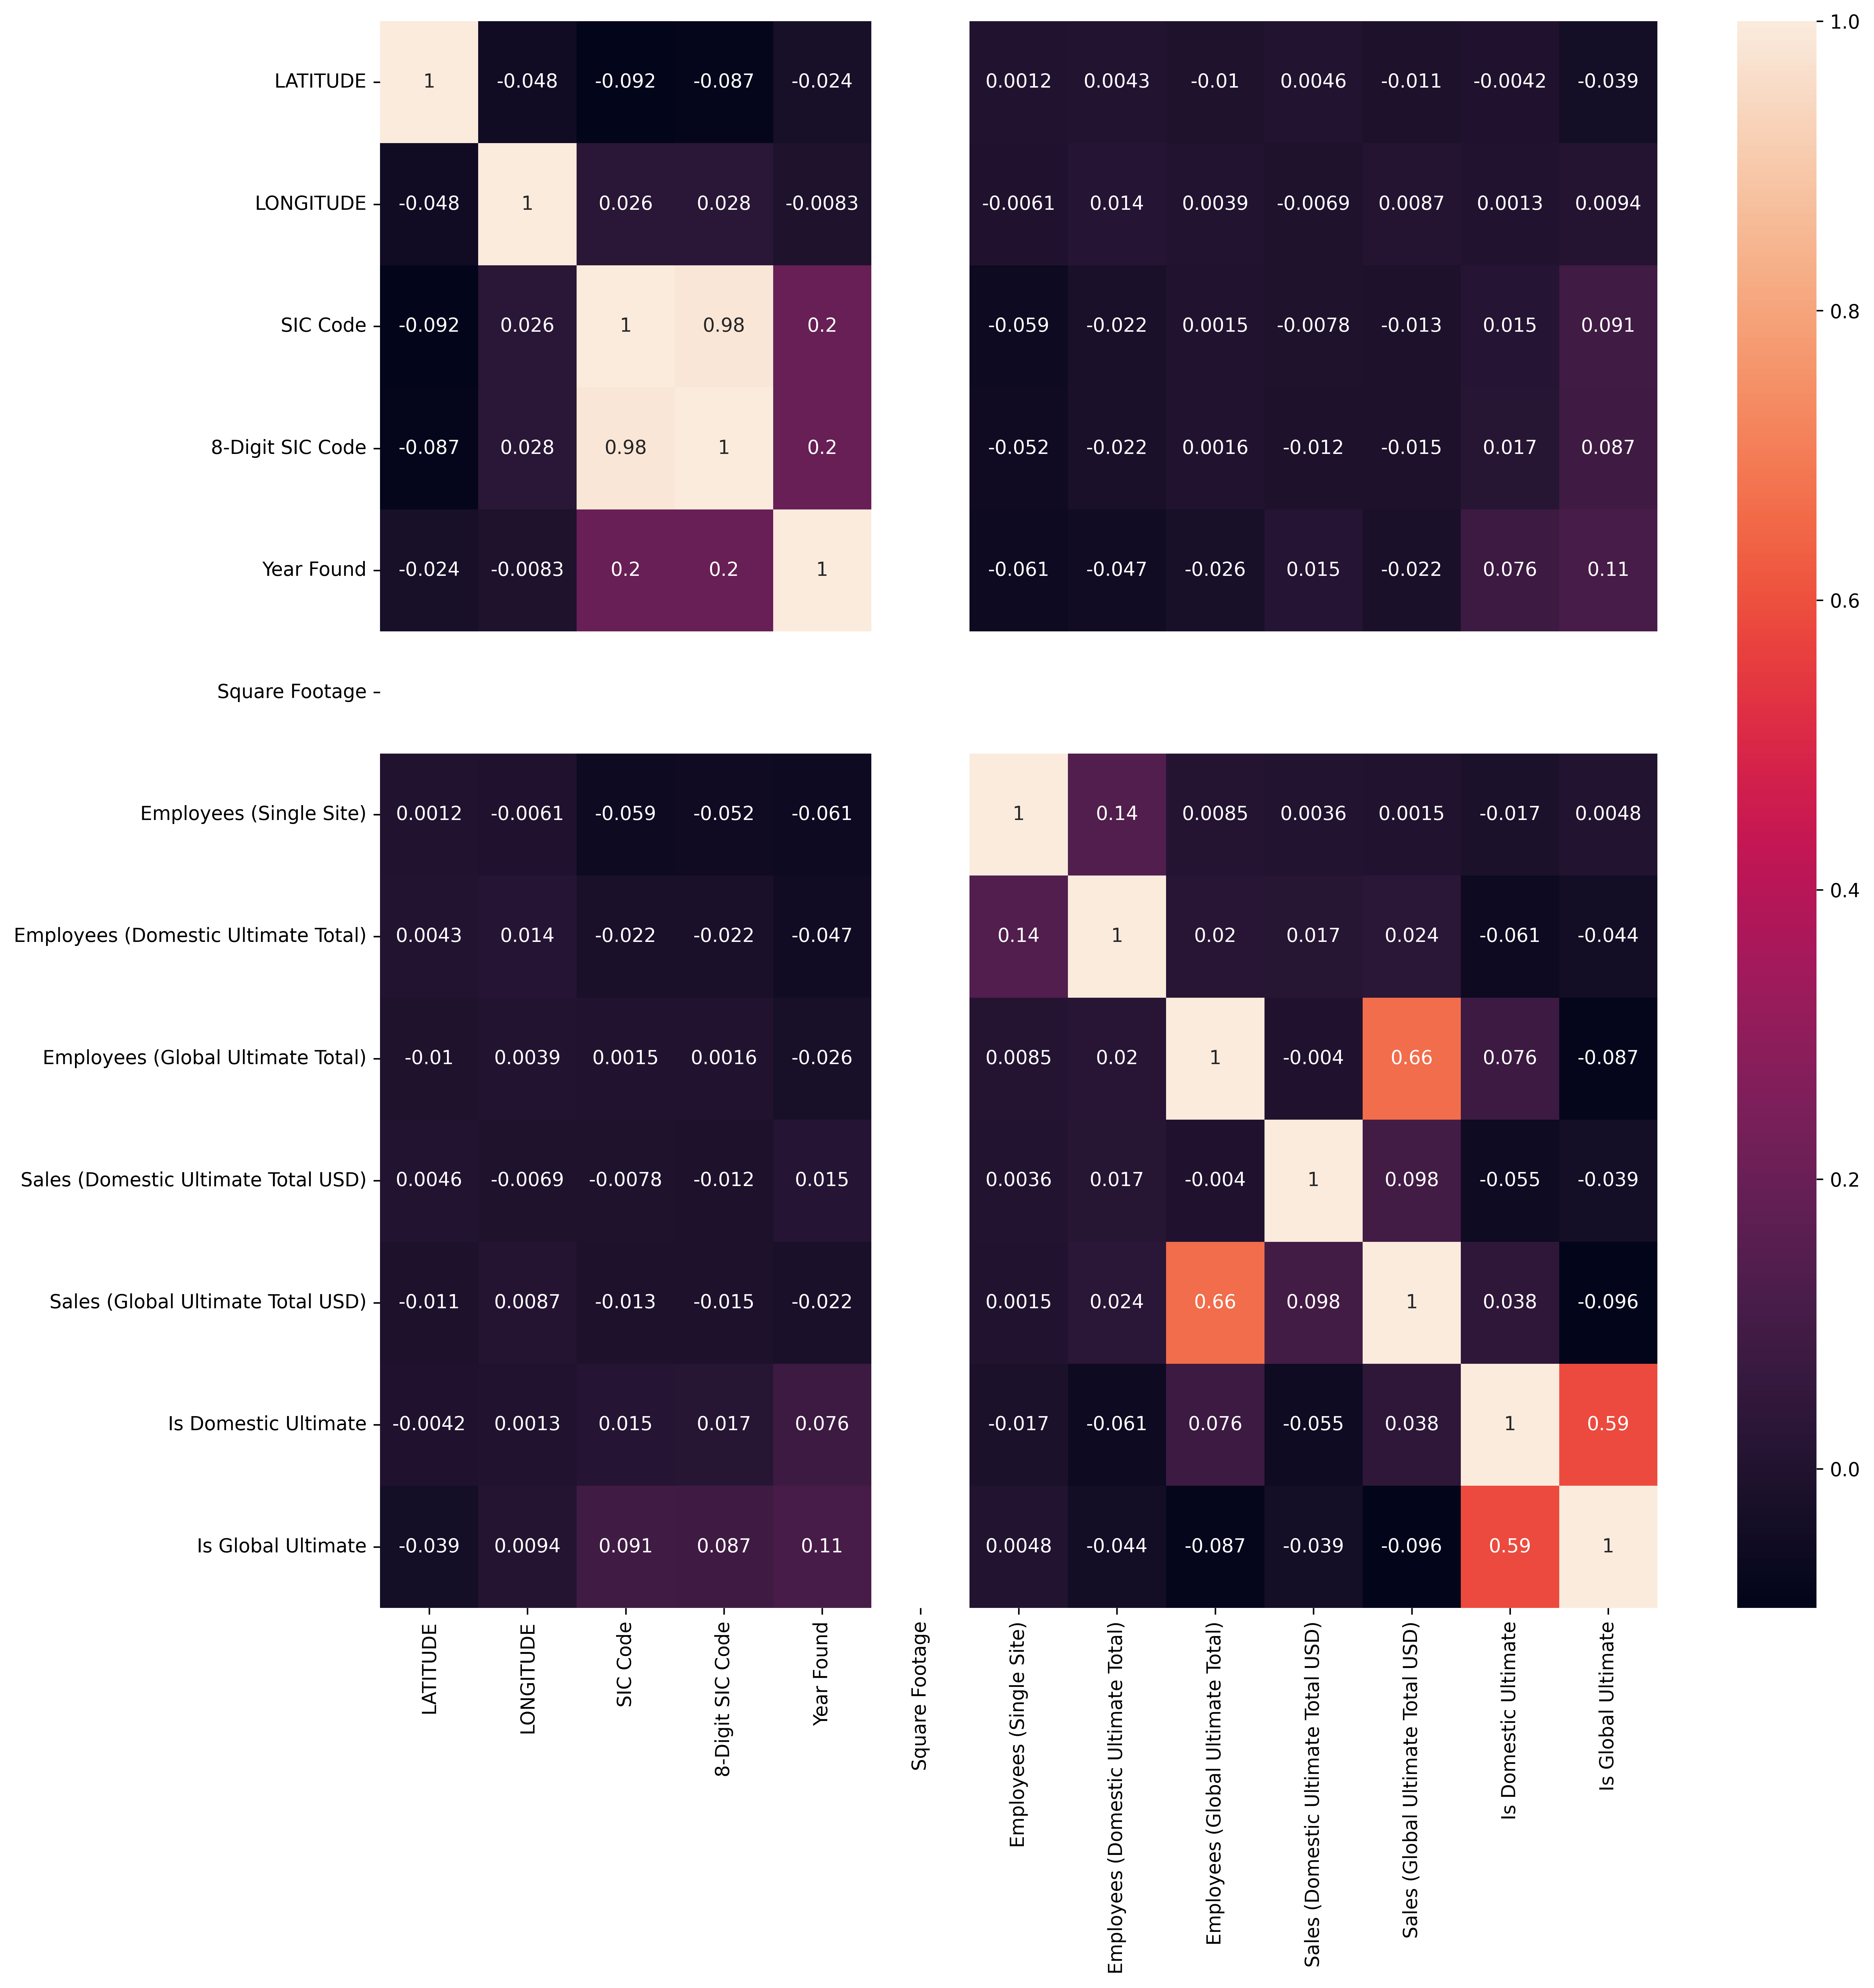

In [71]:
# correlation matrix
numerical_df = df2.select_dtypes(include = ['float64', 'int64'])
correlation_matrix = numerical_df.corr()
correlation_df = pd.DataFrame(correlation_matrix)

import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize = (15, 15), dpi = 480)
sns.heatmap(correlation_df, xticklabels = correlation_df.columns,
            yticklabels = correlation_df.columns, annot = True)

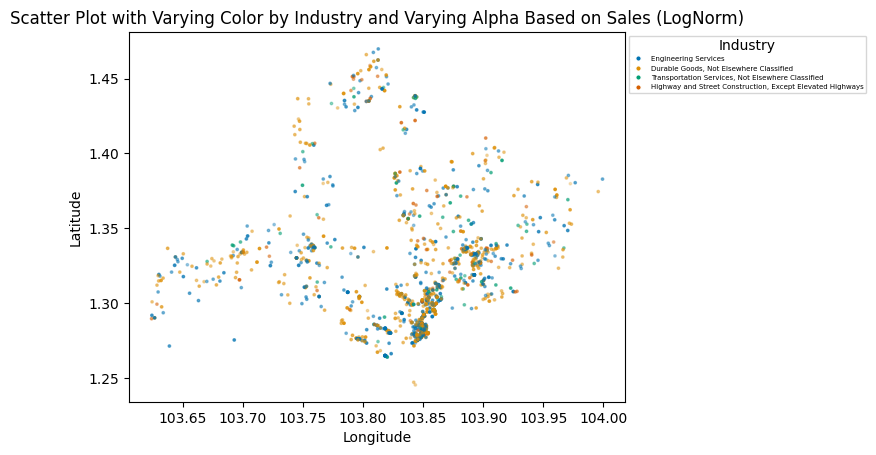

In [27]:
# geospatial analysis
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

filtered_df = df[df['SIC Code'].isin([5099, 1611, 8711, 4789])]
norm = LogNorm()
constant_color = 'blue'
industry_palette = sns.color_palette('colorblind', n_colors = len(filtered_df['Industry'].unique()))
industry_colors = dict(zip(filtered_df['Industry'].unique(), industry_palette))

# scatter plot
scatter = plt.scatter(filtered_df['LONGITUDE'], filtered_df['LATITUDE'], 
                      c=filtered_df['Industry'].map(industry_colors), s = 3, 
                      alpha = norm(filtered_df['Sales (Domestic Ultimate Total USD)']))
legend_labels = filtered_df['Industry'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=industry,
                              markerfacecolor=industry_colors[industry], markersize=4) for industry in legend_labels]
plt.legend(handles=legend_handles, title='Industry', prop={'size': 5}, loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot with Varying Color by Industry and Varying Alpha Based on Sales (LogNorm)')
plt.show()

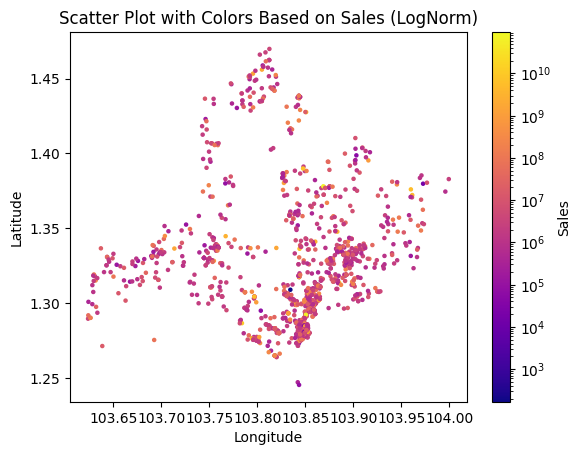

In [30]:
norm = LogNorm()
cmap = 'plasma'
scatter = plt.scatter(filtered_df['LONGITUDE'], filtered_df['LATITUDE'],
                      c = filtered_df['Sales (Domestic Ultimate Total USD)'],
                      cmap = cmap, s = 5, norm = norm)
cbar = plt.colorbar(scatter, label = 'Sales')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot with Colors Based on Sales (LogNorm)')
plt.show()

In [50]:
# feature selection
columns_to_drop = ["error", "Fiscal Year End", "Sales (Global Ultimate Total USD)", "Global Ultimate Company", "Domestic Ultimate Company", "Web Address",
                   "Sales (Global Ultimate Total USD)", "Square Footage", "Company Description", "PostCode", "8-Digit SIC Code", "8-Digit SIC Description", "AccountID",
                   "Parent Company", "City", "Country", "Address", "Address1", "Industry", "Region", "Parent Country", "Global Ultimate Country", "Company", "Import/Export Status"]
df3 = df2.drop(columns = [col for col in columns_to_drop if col in df2.columns], errors = 'ignore')

df3 = df3.dropna(subset = ["Employees (Single Site)", "Employees (Domestic Ultimate Total)", 
                            "Employees (Global Ultimate Total)", "Year Found"])

# data type conversion
df3['Is Domestic Ultimate'] = df3['Is Domestic Ultimate'] == 1
df3['Is Global Ultimate'] = df3['Is Global Ultimate'] == 1

## Model Training and Evaluation

In [55]:
# Gradient Boosting Regressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor

X = df3.drop('Sales (Domestic Ultimate Total USD)', axis = 1)
y = df3['Sales (Domestic Ultimate Total USD)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = GradientBoostingRegressor(random_state = 42)

In [ ]:
# K-fold Cross Validation
n_folds_values = list(range(4, 16))
mean_r2_scores = []
std_r2_scores = []

for n_folds in n_folds_values:
    kf = KFold(n_splits = n_folds, shuffle = True, random_state = 42)
    cv_scores = cross_val_score(model, X_train, y_train, cv = kf, scoring = 'r2')
    
    mean_r2_scores.append(cv_scores.mean())
    std_r2_scores.append(cv_scores.std())

plt.errorbar(n_folds_values, mean_r2_scores, yerr = std_r2_scores,
             marker = 'o', linestyle = '-', label = 'R-squared scores')
plt.xlabel('Number of Folds')
plt.ylabel('R-squared Score')
plt.title('Cross-Validated R-squared Scores for Different Numbers of Folds')
plt.legend()
plt.show()

In [ ]:
# model evaluation metrics
model_10 = GradientBoostingRegressor(random_state = 42)
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
cv_scores = cross_val_score(model, X_train, y_train, cv = kf, scoring = 'r2')

print("Cross-Validation R-squared scores:", cv_scores)
print("Mean R-squared score:", cv_scores.mean())
print("Standard Deviation of R-squared scores:", cv_scores.std())

# train the model on the entire training set
model_10.fit(X_train, y_train)
test_score = model_10.score(X_test, y_test)
print("Test R-squared score:", test_score)

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
import joblib
joblib.dump(model_10, 'base_model.h5')

In [62]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    
    ## data processing and manipulation
    df = hidden_data

    # dealing with missing data
    df = df.dropna(subset = ["LATITUDE", "LONGITUDE"])

    # One-Hot encoding
    df = df[df['Company Status (Active/Inactive)'] == 'Active']
    df['Import/Export Status_Missing'] = df['Import/Export Status'].isna()

    df2 = df.dropna(subset=["Employees (Single Site)", "Employees (Domestic Ultimate Total)", "Employees (Global Ultimate Total)",
                                       "Year Found"])

    df2 = pd.get_dummies(df, columns=['Entity Type'], prefix='Entity_Type')
    df2 = pd.get_dummies(df, columns=['Ownership Type'], prefix='Ownership_Type')
    df2 = pd.get_dummies(df, columns=['Import/Export Status'], prefix='Import_Export_Status')
    df2 = df.drop(columns=[col for col in ["Company Status (Active/Inactive)", "Entity Type", 'Import/Export Status', 'Ownership Type'] if col in df2.columns], errors='ignore')

    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    df2['SIC Code'] = label_encoder.fit_transform(df2['SIC Code'])

    # feature selection
    columns_to_drop = ["error", "Fiscal Year End", "Sales (Global Ultimate Total USD)", "Global Ultimate Company", "Domestic Ultimate Company", "Web Address",
                        "Sales (Global Ultimate Total USD)", "Square Footage", "Company Description", "PostCode", "8-Digit SIC Code", "8-Digit SIC Description", "AccountID",
                        "Parent Company", "City", "Country", "Address", "Address1", "Industry", "Region", "Parent Country", "Global Ultimate Country", "Company", "Import/Export Status"]
    df3 = df2.drop(columns = [col for col in columns_to_drop if col in df2.columns], errors = 'ignore')

    df3 = df3.dropna(subset = ["Employees (Single Site)", "Employees (Domestic Ultimate Total)", 
                                "Employees (Global Ultimate Total)", "Year Found"])

    # data type conversion
    df3['Is Domestic Ultimate'] = df3['Is Domestic Ultimate'] == 1
    df3['Is Global Ultimate'] = df3['Is Global Ultimate'] == 1

    loaded_model = joblib.load('./base_model.h5')
    result = loaded_model.predict(df3) 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!